In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#### Data preprocessing

In [2]:
# Reading in LA County case and death data
# 1/26/2020 through 2/22/2022 for this iteration
la = pd.read_csv('https://raw.githubusercontent.com/nmonozon/modeling-covid-19/main/Datasets/covid-19-los-angeles-county.csv', index_col='date')[0:759]

In [3]:
la.tail()

,day,county,state,fips,cases,deaths
date,,,,,,
2022-02-18,755,Los Angeles,California,6037.0,2777869,30216.0
2022-02-19,756,Los Angeles,California,6037.0,2781027,30300.0
2022-02-20,757,Los Angeles,California,6037.0,2783657,30356.0
2022-02-21,758,Los Angeles,California,6037.0,2784980,30376.0
2022-02-22,759,Los Angeles,California,6037.0,2786153,30411.0


In [4]:
# Column for new cases per day
la['new_cases'] = 0 
for i in range(1,len(la)):
    la['new_cases'].iloc[i] = la['cases'].iloc[i] - la['cases'].iloc[i-1]

C:\Users\Nicolas\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
la['week'] = la['day'] // 7
weekly_la = la.groupby('week')[['new_cases']].sum()
weekly_la['one_week_before'] = weekly_la['new_cases'].shift(1)
weekly_la['change'] = weekly_la['new_cases'].shift(1) - weekly_la['new_cases'].shift(2)
weekly_la.dropna(inplace = True)
weekly_la = weekly_la.iloc[1::]

In [6]:
weekly_la

,new_cases,one_week_before,change
week,,,
3,0,0.0,0.0
4,0,0.0,0.0
5,12,0.0,0.0
6,27,12.0,12.0
7,252,27.0,15.0
...,...,...,...
104,181641,256736.0,-27746.0
105,99977,181641.0,-75095.0
106,42036,99977.0,-81664.0


#### Polynomial Regression model

In [7]:
# Cross validating polynomial regression model
degree = 4
polynomial_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
cv = cross_val_score(polynomial_model, weekly_la.drop(columns = ['new_cases']), 
                     weekly_la['new_cases'], scoring = 'neg_mean_absolute_error', cv = 5)
cv

array([-3.49200997e+03, -3.40384633e+03, -9.62039701e+04, -4.81346396e+03,
       -3.50760158e+06])

In [8]:
# Fitting a degree 4 polynomial
polynomial_model.fit(weekly_la.drop(columns=['new_cases']), weekly_la['new_cases'])
poly_preds = polynomial_model.predict(weekly_la.drop(columns = ['new_cases']))

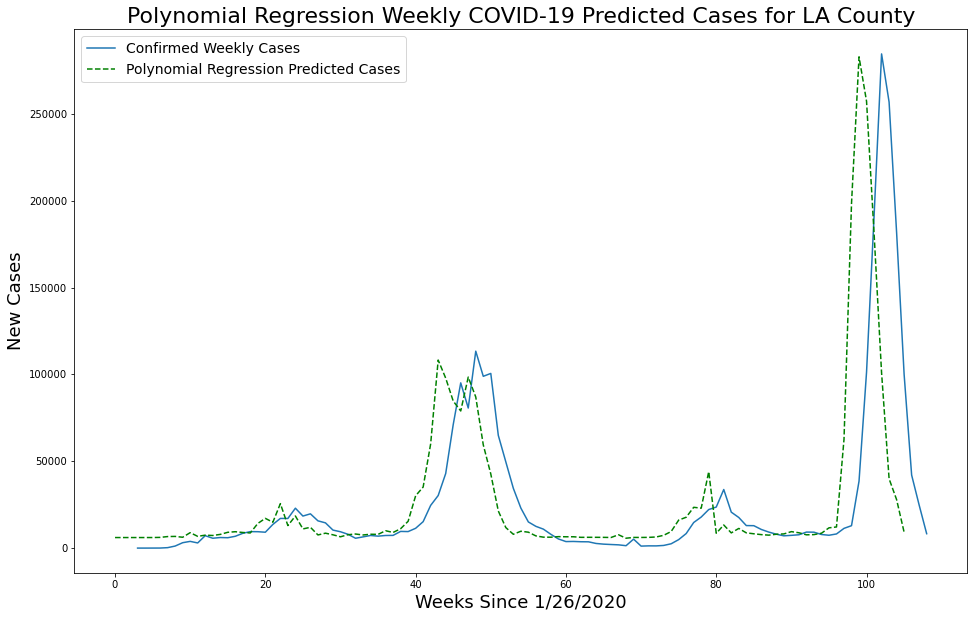

In [9]:
# Visualization
plt.figure(figsize = (16,10))
plt.plot(weekly_la['new_cases'], label = 'Confirmed Weekly Cases')
plt.plot(poly_preds, label = 'Polynomial Regression Predicted Cases', color='green', linestyle='dashed')
plt.xlabel('Weeks Since 1/26/2020', fontsize=18)
plt.ylabel('New Cases', fontsize=18)
plt.title('Polynomial Regression Weekly COVID-19 Predicted Cases for LA County', fontsize=22)
plt.legend(prop={'size': 14})
# plt.savefig("polynomial_regression.png")
# files.download("polynomial_regression.png") 

In [10]:
# MAE and MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print('MAE:', mean_absolute_error(weekly_la['new_cases'], poly_preds))
print('MSE:', mean_squared_error(weekly_la['new_cases'], poly_preds))

MAE: 4521.17527220788
MSE: 61271622.08701846


In [11]:
# Week 
week = 108

In [12]:
# R^2
from sklearn.metrics import r2_score
print('R^2:', r2_score(weekly_la['new_cases'], poly_preds))

R^2: 0.9731798342185494


In [13]:
# Actual data from Week 108
week_actual = weekly_la.loc[week]
week_actual

new_cases           8284.0
one_week_before    24767.0
change            -17269.0
Name: 108, dtype: float64

In [14]:
# Predicted data for Week 108
poly_prediction = polynomial_model.predict(pd.DataFrame(np.array([[week_actual['new_cases'], 
                      week_actual['new_cases'] - week_actual['one_week_before']]]), columns = weekly_la.columns[1:]))
int(poly_prediction)

1518